# Maximum Likelihood Estimation of the Linear Model


In this exercise we will consider the linear regression model. Of
course, when estimated with OLS, the estimator, which minimizes the sum
of squared residuals, has a closed form solution. This also goes for the
maximum likelihood estimator when the residuals are assumed Gaussian. We
will however do the maximization numerically using the scipy library and the `optimize` class, more specifically we will use its `minimize` function. The purpose of this exercise is to learn to do
numerical maximization and to be familiar with $M$-estimators by viewing
the maximum likelihood estimator of the linear model as an
$M$-estimator.

In [1]:
# general modules 
import numpy as np
import pandas as pd 
from matplotlib import pyplot as plt
from scipy.optimize import minimize

%load_ext autoreload
%autoreload 2
 
# Code for this week 
import estimation_ante as est
import LinearModel_ante as lm  

# Set random seed
seed = 42
rng = np.random.default_rng(seed=seed)

In [2]:
import seaborn as sns
sns.set_theme()
plt.rcParams.update({
    #"text.usetex": True, # LaTeX can sometimes be tricky to get working but makes graphs prettier :) 
    "font.family": "serif", 
    "font.size":18 
})

# The Model

We consider a linear model with the following characteristics

$$y_{i}=\beta _{0}+\beta _{1}x_{1i}+....+\beta _{k-1}x_{k-1i}+u _{i} \quad i=1,..,N$$

with $u_{i} | X_i \sim N(0,\sigma^2)$.

The (conditional) likelihood contribution for observation $i$ is,
$$f\left(y_{i}\left|\mathbf{x}_{i};\beta,\sigma^{2}\right.\right)
  =\frac{1}{\sqrt{2\pi\sigma^{2}}} \exp\left\{ -\frac{1}{2} \frac{\hat{u}_{i}^{2}}{\sigma^{2}}\right\},$$
where
$\hat{u}_{i}=y_{i}- \sum_{k=1}^K \beta_k x_{ik}$. (Remember $\hat{u}_{i}$ depends on $\beta$)

Thus, the loglikelihood contribution is 
$$
\ell_i(\theta) = - \frac{1}{2}\log (2 \pi) - \frac{1}{2}\log(\sigma^2) - \frac{1}{2}\frac{\hat{u}_i^2}{\sigma^2}
$$

Often the term $-\frac{1}{2}\log\left(2\pi\right)$ is dropped as it does not change with 
$\beta$ or $\sigma$ and thus does not affect the optimization. 

Finally, our optimizer will be solving the problem 
$$ \min_\theta \frac{1}{N} \sum_{i=1}^N q(\theta, y_i, x_i),$$ 
where the criterion function is the negative loglikelihood, $q(\theta,y_i,x_i) = -\ell_i(\theta)$. 
Again, we can drop the factor $N^{-1}$ as it does not affect the optimization. 

In [3]:
# Simulate dataset
n = 100
K = 2 # two regressors, a constant and one (real) regressor
beta = np.ones((K,1))  # First is constant
sigma = 3
true_theta = np.vstack([beta, sigma])
y, x = lm.sim_data(n, true_theta, rng)

# Find some starting values 
theta0 = lm.starting_values(y, x, )
theta0 = 0.8*theta0 # scale them by 0.8 to make the problem a little harder 

# Question 1: Write a function for the likelihood contribution.
Open the file `LinearModel.py`, and fill in the function `loglikelihood` with the **likelihood contribution**. It should return an $N \times 1$ vector of likelihood contributions.

*Hint:* The sum of the likelihood contributions should be close to -162.8, given `theta0, x, y`, which I have written a function to check for you, so you know if you have written it correctly.

In [4]:
# Fill in the missing parts of the lm.loglikelihood() function.
# First, calculate the residual.
# Then calculate the likelihood value, using the likelihood contribution equation from above.
# Test if you got it right with the cell below. You might have to "reseed" by running the first cell in this notebook again.

In [7]:
seed = 42
np.isclose(np.sum(lm.loglikelihood(theta0, y, x)), -162.800)

True

# Question 2: Estimate Parameters 

Now finish up the `estimation` function, which takes a function to minimize `func`, starting values `theta0`, the data `y` and `x`, and what type of variance to use `cov_type`.

You need to use the `minimize` function, which takes the following inputs: the objective function `obj_func`, and the starting values `theta0`.

You also need to finish up the `variance` function, which takes the function `func` (not the objective function), the data `y` and `x`, the results from the minimizer `result`, and finally what type of variance to calculate `cov_type`.

## 2.a Practice Estimation with `minimize`

1. Create a `lambda` function, `Q`, taking only one input, `theta`, and returning the negative mean loglikelihood. 
    * ***Hint:*** Watch this video to learn about functions in Python: https://youtu.be/watch?v=loF8zsPaIjs. 
2. Evaluate `Q(theta0)` to test that it works. 
3. Call `minimize`, starting from `theta0`, with options having `disp` set to `True`, and the optimization algorithm (`method`) set to `BFGS`. 

In [9]:
# 1. function handle to the objective 
Q = lambda theta : np.mean(lm.q(theta, y, x)) # just a function of one variable, theta

In [8]:
# 2. starting values 
print(theta0) # we defined these above, no need to redefine

[[0.78886166]
 [1.08601912]
 [2.35222344]]


In [13]:
# 3. call scipy minimize 
result = minimize(Q, theta0.flatten(), options={'disp':True}, method='BFGS')

Optimization terminated successfully.
         Current function value: 1.568403
         Iterations: 15
         Function evaluations: 64
         Gradient evaluations: 16


You should get 

Optimization terminated successfully.

         Current function value: 1.568403

         Iterations: 15

         Function evaluations: 64
         
         Gradient evaluations: 16

# Question 3: Standard Errors

**Tasks**: 
* Fill in `estimation.estimate()`: For the estimate function, you need to read the documentation for the optimize.minimize function, to pass the obj_func and theta0 to that function.
    * ***Bonus:*** Make sure that `estimate()` passes the inputs `options` and the optional `kwargs` correctly to `optimize.minimize`. The options struct can e.g. ask the optimizer to print or not print final convergence output by setting `options = {'disp': True}` (or `False`). The `kwargs` can include things like controlling which algorithm is used for optimization, e.g. `method='BFGS'`. 
* Fill in `estimation.variance()`: implement all three options for $\text{Avar}(\hat{\theta}$) described below. 

## Theory: The Three Asymptotic Variance Estimators

The log-likelihood function is a nonlinear function, which must in
general be maximized numerically in order to obtain the ML estimates.
In general, for $M$-estimators, we know that 
$$
\sqrt{N}\left( \boldsymbol{\hat{\theta}}-\boldsymbol{\theta }_{0}\right) 
\overset{d}{\rightarrow} \mathcal{N} \left(\mathbf{0}, \mathbf{A}_{0}^{-1} \mathbf{B}_0 \mathbf{A}_{0}^{-1} \right). 
$$ 

For Maximum Likelihood (ML) estimators specifically, the *Information Matrix 
Equality* holds, which implies that 
$$ \mathbf{A}_{0} = \mathbf{B}_{0}. $$ 
This means that the asymptotic variance matrix simplifies so that 
$$ \mathbf{A}_{0}^{-1} \mathbf{B}_0 \mathbf{A}_{0}^{-1} = \mathbf{A}_{0}^{-1} = \mathbf{B}_{0}^{-1}.$$ 

This means that we have three valid ways of estimating the asymptotic variance 
matrix of our parameter esimates: 

$\widehat{\text{Avar}}( \boldsymbol{\hat{\theta}})$ can be taken to be any
of the three options
1. $\widehat{\text{Avar}}( \boldsymbol{\hat{\theta}}) = N^{-1} \hat{\mathbf{A}}^{-1}$: the `Hessian`, 
2. $\widehat{\text{Avar}}( \boldsymbol{\hat{\theta}}) = N^{-1} \hat{\mathbf{B}}^{-1}$: the `Outer Product`,  
3. $\widehat{\text{Avar}}( \boldsymbol{\hat{\theta}}) = N^{-1} \hat{\mathbf{A}}^{-1} \hat{\mathbf{B}} \hat{\mathbf{A}}^{-1} $: the `Sandwich`: viewed as a more "robust" option.  


where the components matrices are
$$
\begin{aligned}
\quad \mathbf{\hat{A}} 
    &= -\frac{1}{N} \left[ \sum_{i=1}^{N}\mathbf{H}_{i}( \boldsymbol{\hat{\theta}}) \right] 
\\
\quad  \mathbf{\hat{B}}
    &= \frac{1}{N}
        \left[ \sum_{i=1}^{N} \mathbf{s}_{i}( \boldsymbol{\hat{\theta}}) 
                              \mathbf{s}_{i}( \boldsymbol{\hat{\theta}})^{\prime}
        \right].
\end{aligned}
$$ 

**Note**: Wooldridge has some confusing notation. In the notation above, the score, $\mathbf{s}_{i}( \boldsymbol{\hat{\theta}})$, and Hessian $\mathbf{H}_{i}( \boldsymbol{\hat{\theta}})$ are the first and second order derivatives of the log likelihood contribution, $\ell_i(\theta)$, evaluated at the estimated parameters, $\boldsymbol{\hat{\theta}}$ - not the first and second order derivatives of $q(\theta,y_i,x_i) = - \ell_i(\theta)$. This code implements an M-estimator that minimizes $q(\theta,y_i,x_i)$. The only difference in the variance estimators is that there is no minus sign in front of the average Hessian in the expression of $\mathbf{\hat{A}}$. So when you implement the variance estimators you should not include the minus sign in front of the average Hessian.


*Programming hint:* To calculate the variance you have to do the following:

* `Hessian`: The ex ante code computes the *sum of numerical Hessians* $K \times K$ matrix, `H_sum`. You need to compute the $K \times K$ average Hessian, $\mathbf{\hat{A}}$. Finally, calculate the variance using:
$$
\widehat{\text{Avar}}( \boldsymbol{\hat{\theta}}) = \frac{1}{N}\mathbf{\hat{A}}^{-1}
$$
* `Outer Product`: the ex ante code computes the *numerical gradient* $N \times K$ matrix, `s`. You need to compute the $K \times K$ outer product of the scores, 
$ \mathbf{s}' \mathbf{s} = \sum_{i=1}^N \mathbf{s}_i \mathbf{s}_i', $
($\mathbf{s}_i$ is $K \times 1$ in this notation) and then use this to form $\hat{\mathbf{B}} = N^{-1} \mathbf{s}' \mathbf{s}$. Finally, calculate the variance using:
$$
\widehat{\text{Avar}}( \boldsymbol{\hat{\theta}}) = \frac{1}{N}\mathbf{\hat{B}}^{-1}
$$

### Question 3.a: The 'Hessian' Estimator

Compute standard errors using the `Hessian` estimator. 

In [18]:
results_hes = est.estimate(lm.q, theta0, y, x, cov_type='Hessian')

label = ['beta 1', 'beta 2', 'sigma2']
est.print_table(label, results_hes, title='Maximum Likelihood results', num_decimals=3)

Optimization terminated successfully.
         Current function value: 1.568403
         Iterations: 15
         Function evaluations: 64
         Gradient evaluations: 16
Optimizer succeeded after 15 iter. (64 func. evals.). Final criterion:    1.568.
Maximum Likelihood results


,theta,se,t
beta 1,0.986,0.292,3.381
beta 2,1.358,0.377,3.604
sigma2,2.911,0.206,14.142


Results should look like this: 

|        | theta |    se |      t |
|-------:|------:|------:|-------:|
| beta 1 | 0.986 | 0.292 |  3.381 |
| beta 2 | 1.358 | 0.377 |  3.604 |
| sigma2 | 2.911 | 0.206 | 14.142 |

### Question 3.b: The 'Outer Product' Estimator

Estimate parameters and compute standard errors using the `Outer Product` estimator. (This is the *default* variance estimator in `est.estimate`.)

In [20]:
results_out = est.estimate(lm.q, theta0, y, x) #since it's the defalt, we don't actively write "cov_type = 'Outer product'" but it would yield the same result if we did
est.print_table(label, results_out, title='Maximum Likelihood results', num_decimals=3)

Optimization terminated successfully.
         Current function value: 1.568403
         Iterations: 15
         Function evaluations: 64
         Gradient evaluations: 16
Optimizer succeeded after 15 iter. (64 func. evals.). Final criterion:    1.568.
Maximum Likelihood results


,theta,se,t
beta 1,0.986,0.306,3.225
beta 2,1.358,0.397,3.418
sigma2,2.911,0.230,12.656


Your table should look a little like this: <br>

Maximum Likelihood results <br>

|        | theta |    se |      t |
|-------:|------:|------:|-------:|
| beta 1 | 0.986 | 0.306 |  3.225 |
| beta 2 | 1.358 | 0.397 |  3.418 |
| sigma2 | 2.911 | 0.230 | 12.656 |

### Question 3.c: The 'Sandwich' Estimator

Compute standard errors using the `Sandwich` estimator. 

In [21]:
results_san = est.estimate(lm.q, theta0, y, x, cov_type='Sandwich')
est.print_table(label, results_san, title='Maximum Likelihood results', num_decimals=3)

Optimization terminated successfully.
         Current function value: 1.568403
         Iterations: 15
         Function evaluations: 64
         Gradient evaluations: 16
Optimizer succeeded after 15 iter. (64 func. evals.). Final criterion:    1.568.
Maximum Likelihood results


,theta,se,t
beta 1,0.986,0.294,3.357
beta 2,1.358,0.362,3.753
sigma2,2.911,0.195,14.961


Results should look like this: 

|        | theta |    se |      t |
|-------:|------:|------:|-------:|
| beta 1 | 0.986 | 0.294 |  3.357 |
| beta 2 | 1.358 | 0.362 |  3.753 |
| sigma2 | 2.911 | 0.195 | 14.961 |


# Question 4: Monte Carlo Study. 

**Task:** Conduct a Monte Carlo study for different sample sizes. 

Conduct a Monte Carlo study of the Maximum Likelihood estimator. Try
various values of $N$ to illustrate the consistency of the
estimator. Is the estimator biased? Compare the three types of
standard error estimates to the Monte Carlo sampling standard
deviation. Is the estimator of $\sigma$ consistent?

In [22]:
NN = [5, 15, 50, 200]  # Sample size
S = 1_000  # Number of replications
P = len(theta0)

In [23]:
# Initialize containers for all MX experiments
theta_n = np.zeros((len(NN), P, S))
se_theta_n = np.zeros((len(NN), P, S))
MC_se = np.zeros((len(NN), P))

In [24]:
for i, N in enumerate(NN): # loop over sample sizes 
    print(f'N = {N:5d}: {i+1}/{len(NN)}')
    for s in range(S): # for each Monte Carlo replication 
        y, x = lm.sim_data(N, true_theta, rng)
        theta0 = lm.starting_values(y, x) * 0.8# find starting values, and scale them slightly by 0.8
        results = est.estimate(lm.q, theta0, y, x, options={'disp':False}) # display off to avoid cluttering output 
        
        theta_n[i, :, s] = results['theta_hat']
        se_theta_n[i, :, s] = results['se']
    
    MC_se[i, :] = np.std(theta_n[i,:,:], axis=1, ddof=1)

N =     5: 1/4
N =    15: 2/4
N =    50: 3/4
N =   200: 4/4


### Plotting the results

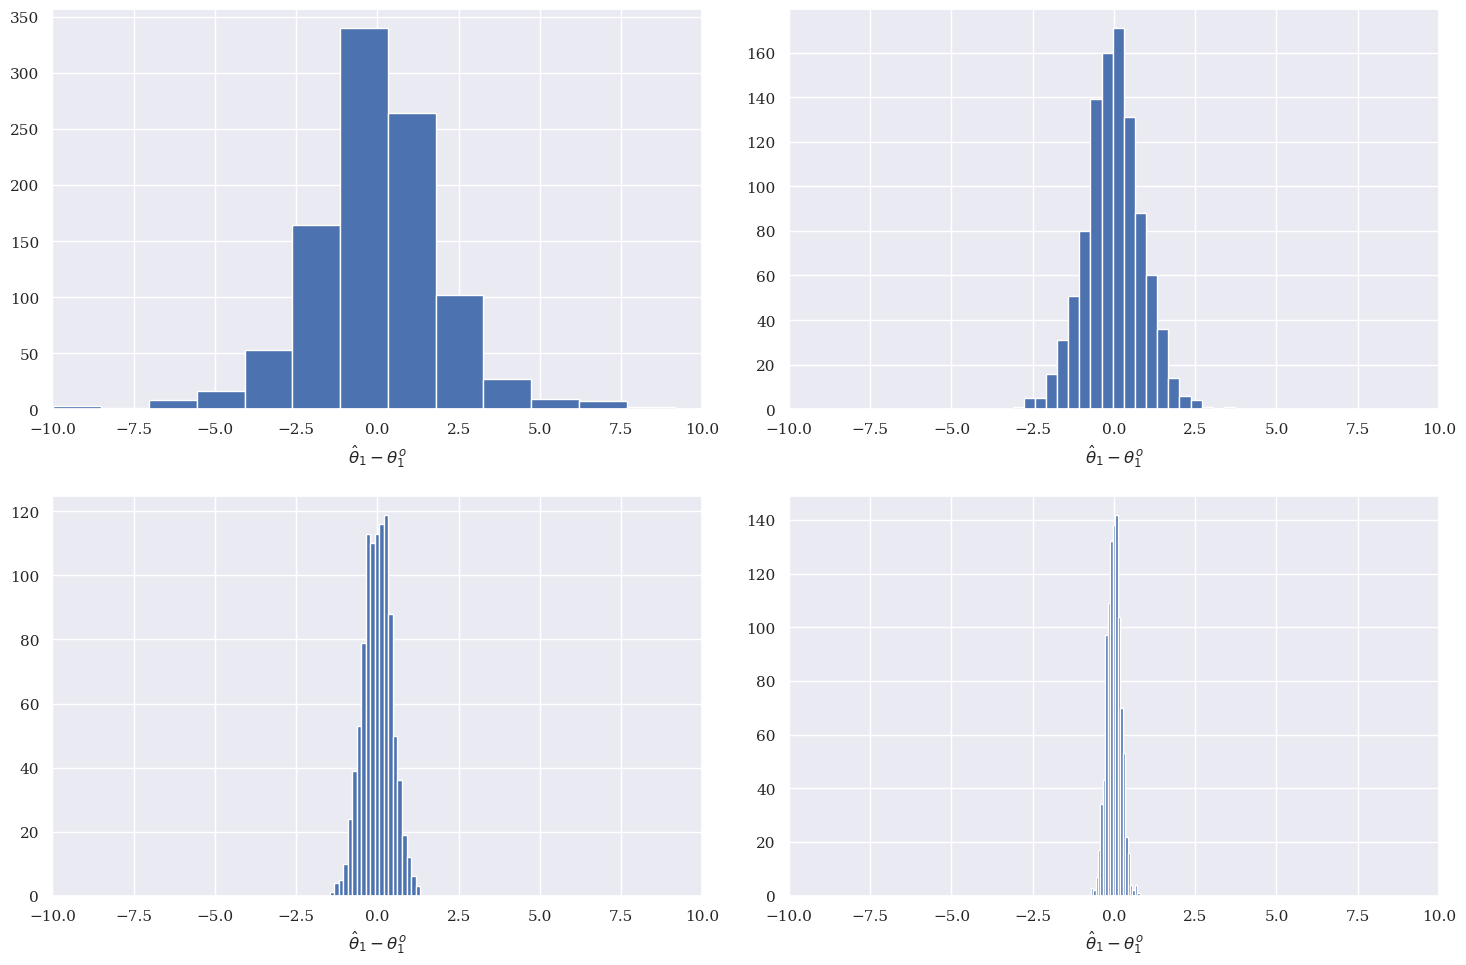

In [25]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel() 
i_theta = 1 # second beta, i.e. not the constant 
theta_diff = theta_n[:, i_theta, :] - true_theta[i_theta, 0]

for i, ax in enumerate(axes):
    ax.hist(theta_diff[i,:], bins=20)
    ax.set_xlim(-10, 10)
    ax.set_xlabel('$\\hat{\\theta}_1 - \\theta^o_1$')

plt.tight_layout()

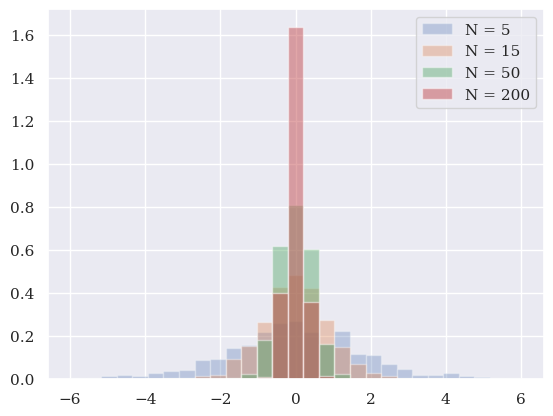

In [26]:
fig, ax = plt.subplots()
aa = np.linspace(0.3,0.5,len(NN))
for i, N in enumerate(NN): 
    xx = np.linspace(-6,6,30)
    ax.hist(theta_diff[i, :], bins=xx, alpha=aa[i], label=f'N = {N}', density=True)
ax.legend(); 

### Same graph, scaled by $\sqrt{N}$

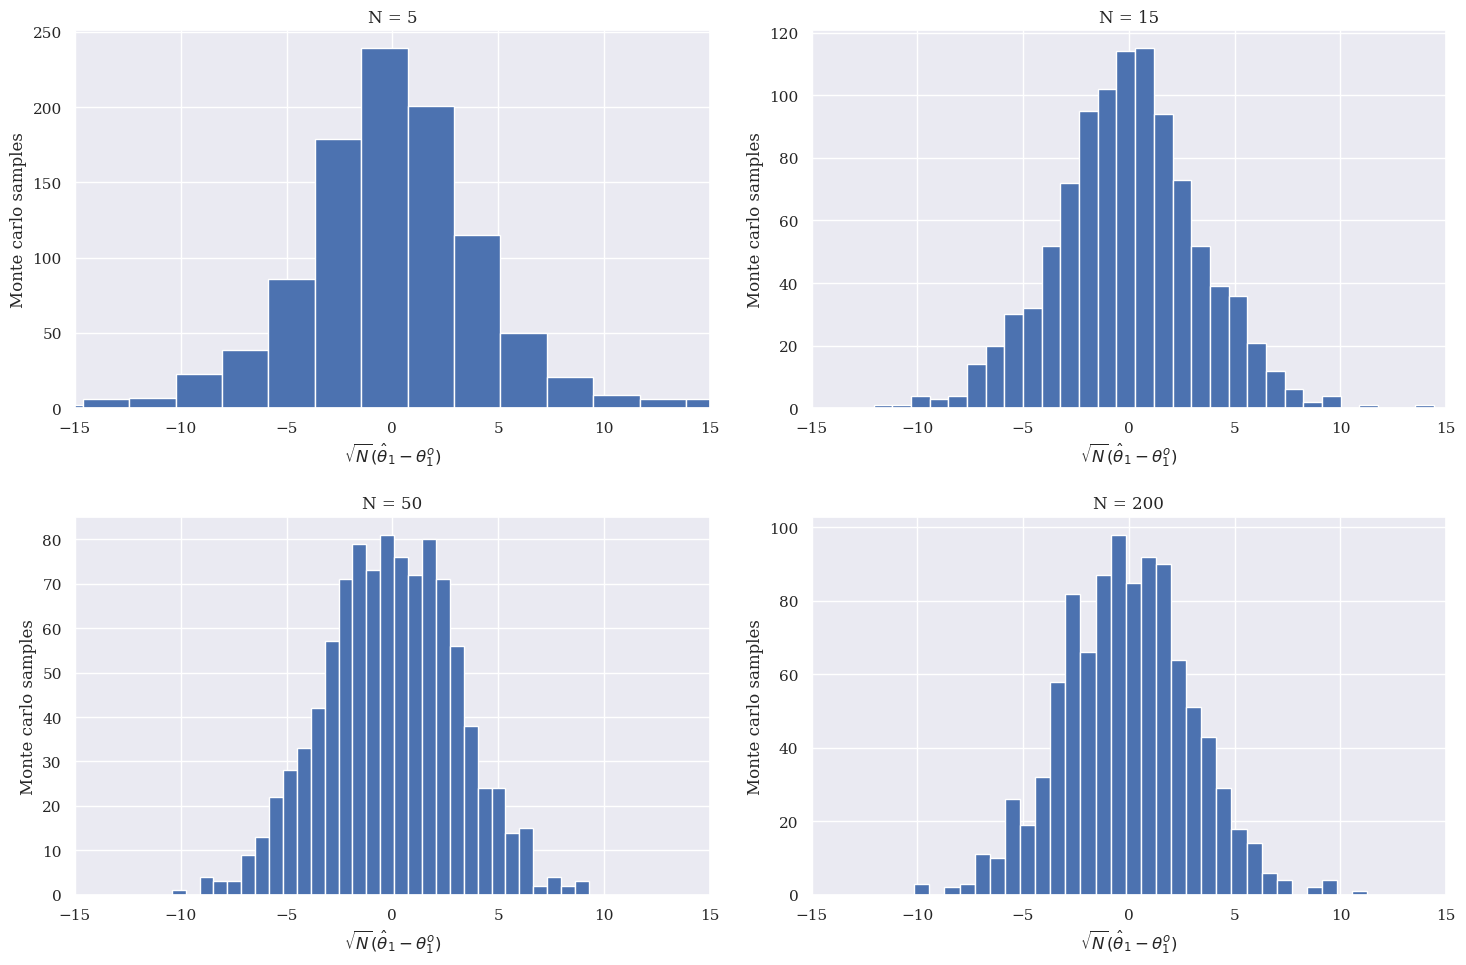

In [27]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel() 
i_theta = 1 # second beta, i.e. not the constant 
theta_diff = theta_n[:, i_theta, :] - true_theta[i_theta, 0]

for i, ax in enumerate(axes):
    ax.hist(theta_diff[i,:] * np.sqrt(NN[i]), bins=30)
    ax.set_xlim(-15, 15)
    
    ax.set_xlabel(f'$\sqrt{{N}} (\\hat{{\\theta}}_{i_theta} - \\theta^o_{i_theta})$')
    ax.set_ylabel('Monte carlo samples')
    ax.set_title(f'N = {NN[i]}')

plt.tight_layout()

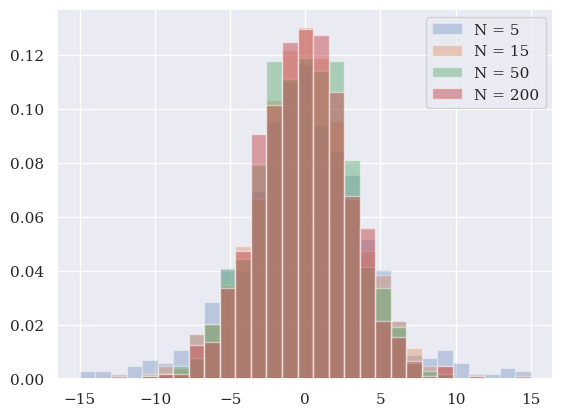

In [28]:
fig, ax = plt.subplots()
aa = np.linspace(0.3,0.5,len(NN))
for i, N in enumerate(NN): 
    xx = np.linspace(-15,15,30)
    ax.hist(theta_diff[i, :] * np.sqrt(NN[i]), bins=xx, alpha=aa[i], label=f'N = {N}', density=True)
ax.legend(); 

# Question 5: Alternative Minimization Algorithms

**Task:** Estimate the model using alternative minimization algorithms (the input `method` to `minimize`). Compare how many function evaluations they take and whether they converge to the global minimum. 

* `BFGS`: The default algorithm (Newton with approximated Hessian and numerical gradients), 
* `CG`: Newton with numerical Hessian and gradients,  
* `Nelder-Mead`: Gradient-free optimizer, 
* `Powell`: Another gradient-free optimizer. 

***Hint:*** `est.estimate()` accepts various extra args, which are by default just passed to `scipy.optimize.minimize`. Try alternatives for `method` (the algorithm). 

***Note:*** The gradient-free optimizers do not return an inverse Hessian, so we can only compute the Outer Product variance matrix for those (unless we compute the Hessian numerically). 

In [29]:
N = 100
y, x = lm.sim_data(N, true_theta, rng)
theta0 = lm.starting_values(y, x)*0.8 # make the minimisation problem a little harder

results_BFGS = est.estimate(lm.q, theta0, y, x, options={'disp':False}) # the default option is method='BFGS'
results_CG   = est.estimate(lm.q, theta0, y, x, options={'disp':False}, method = 'CG')
results_NM   = est.estimate(lm.q, theta0, y, x, options={'disp':False}, method = 'Nelder-Mead')
results_PO   = est.estimate(lm.q, theta0, y, x, options={'disp':False}, method = 'Powell')

In [30]:
print(f'--- BFGS ---')
print(est.print_table(label, results_BFGS))

print(f'\n--- CG ---')
print(est.print_table(label, results_CG))

print(f'\n--- Nelder-Mead---')
print(est.print_table(label, results_NM))

print(f'\n--- Powell ---')
print(est.print_table(label, results_PO))

--- BFGS ---
Optimizer succeeded after 14 iter. (60 func. evals.). Final criterion:    1.533.
Results
         theta      se        t
beta 1  0.6397  0.2862   2.2351
beta 2  0.4773  0.2920   1.6345
sigma2  2.8084  0.1992  14.0965

--- CG ---
Optimizer succeeded after 8 iter. (76 func. evals.). Final criterion:    1.533.
Results
         theta      se        t
beta 1  0.6397  0.2862   2.2354
beta 2  0.4774  0.2920   1.6345
sigma2  2.8084  0.1992  14.0964

--- Nelder-Mead---
Optimizer succeeded after 64 iter. (116 func. evals.). Final criterion:    1.533.
Results
         theta      se        t
beta 1  0.6397  0.2862   2.2351
beta 2  0.4773  0.2921   1.6343
sigma2  2.8084  0.1992  14.0963

--- Powell ---
Optimizer succeeded after 2 iter. (62 func. evals.). Final criterion:    1.533.
Results
         theta      se        t
beta 1  0.6396  0.2862   2.2348
beta 2  0.4773  0.2921   1.6342
sigma2  2.8084  0.1992  14.0963


Expected results (NB these are sensitive to how many times you've created synthetic data using the monte carlo simulations above - try re-running the entire notebook after restarting your kernel if your results dont match): 

In [ ]:
# --- BFGS ---
# Optimizer succeeded after 14 iter. (60 func. evals.). Final criterion:    1.533.
#Results
#         theta      se        t
# beta 1  0.6397  0.2862   2.2351
# beta 2  0.4773  0.2920   1.6345
# sigma2  2.8084  0.1992  14.0965

# --- CG ---
# Optimizer succeeded after 8 iter. (76 func. evals.). Final criterion:    1.533.
# Results
#          theta      se        t
# beta 1  0.6397  0.2862   2.2354
# beta 2  0.4774  0.2920   1.6345
# sigma2  2.8084  0.1992  14.0964

# --- Nelder-Mead ---
# Optimizer succeeded after 64 iter. (116 func. evals.). Final criterion:    1.533.
# Results
#          theta      se        t
# beta 1  0.6397  0.2862   2.2351
# beta 2  0.4773  0.2921   1.6343
# sigma2  2.8084  0.1992  14.0963

# --- Powell ---
# Optimizer succeeded after 2 iter. (69 func. evals.). Final criterion:    1.533.
# Results
#          theta      se        t
# beta 1  0.6396  0.2862   2.2348
# beta 2  0.4773  0.2921   1.6342
# sigma2  2.8084  0.1992  14.0963